In [5]:
import torch
import torchvision
import matplotlib.pyplot as plt
from utils import accuracy
from get_dataset import get_cifar100_data_loaders

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# CIFAR-100 数据加载器
cifar100_train_loader, cifar100_test_loader = get_cifar100_data_loaders(batch_size=256)

def finetune_resnet18(model, train_loader, test_loader, epochs=15, lr=0.0005, weight_decay=0.0):
    # Freeze all layers except the final fully connected layer
    for param in model.parameters():
        param.requires_grad = False

    model.fc = torch.nn.Linear(512, 100)
    for param in model.fc.parameters():
        param.requires_grad = True
        
    model = model.to(device)
    criterion = torch.nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    top1_train_accuracy_list = []
    top1_accuracy_list = []
    top5_accuracy_list = []
    epoch_list = []
    train_loss_list = []
    test_loss_list = []

    for epoch in range(epochs):
        model.train()
        top1_train_accuracy = 0
        train_loss = 0
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            logits = model(x_batch)
            loss = criterion(logits, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            top1 = accuracy(logits, y_batch, topk=(1,))
            top1_train_accuracy += top1[0]

        top1_train_accuracy /= len(train_loader)
        train_loss /= len(train_loader)
        
        model.eval()
        top1_accuracy = 0
        top5_accuracy = 0
        test_loss = 0
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                logits = model(x_batch)
                loss = criterion(logits, y_batch)
                test_loss += loss.item()
                top1, top5 = accuracy(logits, y_batch, topk=(1, 5))
                top1_accuracy += top1[0]
                top5_accuracy += top5[0]

        top1_accuracy /= len(test_loader)
        top5_accuracy /= len(test_loader)
        test_loss /= len(test_loader)

        top1_train_accuracy_list.append(top1_train_accuracy.item())
        top1_accuracy_list.append(top1_accuracy.item())
        top5_accuracy_list.append(top5_accuracy.item())
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
        epoch_list.append(epoch + 1)
        
        print(f"Epoch {epoch}\tTop1 Train accuracy: {top1_train_accuracy.item()}\tTop1 Test accuracy: {top1_accuracy.item()}\tTop5 Test accuracy: {top5_accuracy.item()}\tTrain loss: {train_loss}\tTest loss: {test_loss}")

    return top1_train_accuracy_list, top1_accuracy_list, top5_accuracy_list, train_loss_list, test_loss_list, epoch_list


In [6]:

# 加载ImageNet预训练的ResNet-18
imagenet_resnet18 = torchvision.models.resnet18(pretrained=True)

# 微调 ImageNet 预训练的 ResNet-18
imagenet_top1_train_accuracy, imagenet_top1_test_accuracy, imagenet_top5_test_accuracy, imagenet_train_loss, imagenet_test_loss, epoch_list = finetune_resnet18(
    imagenet_resnet18, cifar100_train_loader, cifar100_test_loader)


Epoch 0	Top1 Train accuracy: 12.302694320678711	Top1 Test accuracy: 20.283203125	Top5 Test accuracy: 44.453125	Train loss: 4.004885920456478	Test loss: 3.569962960481644
Epoch 1	Top1 Train accuracy: 22.37922477722168	Top1 Test accuracy: 23.59375	Top5 Test accuracy: 48.84765625	Train loss: 3.3759357175048517	Test loss: 3.3571465492248533
Epoch 2	Top1 Train accuracy: 25.753347396850586	Top1 Test accuracy: 24.8828125	Top5 Test accuracy: 50.712890625	Train loss: 3.176438096834689	Test loss: 3.271150994300842
Epoch 3	Top1 Train accuracy: 27.640703201293945	Top1 Test accuracy: 25.361328125	Top5 Test accuracy: 51.8359375	Train loss: 3.062744303625457	Test loss: 3.2258732497692106
Epoch 4	Top1 Train accuracy: 28.860410690307617	Top1 Test accuracy: 25.5859375	Top5 Test accuracy: 52.40234375	Train loss: 2.984886793457732	Test loss: 3.19923797249794
Epoch 5	Top1 Train accuracy: 29.94618797302246	Top1 Test accuracy: 25.87890625	Top5 Test accuracy: 52.763671875	Train loss: 2.926402916713637	Test lo

In [7]:
# 加载通过自监督学习训练的 ResNet-18
checkpoint_path = '/root/Lab3-1/logs/simclr_TIN_lr0.0001_wd0_temp0.03_t512_e80/checkpoint_0080.pth.tar'
ssl_resnet18 = torchvision.models.resnet18(pretrained=False)
ssl_resnet18.fc = torch.nn.Linear(512, 100)  
checkpoint = torch.load(checkpoint_path, map_location=device)

# 加载自监督预训练权重
state_dict = checkpoint['state_dict']
for k in list(state_dict.keys()):
    if k.startswith('backbone.') and not k.startswith('backbone.fc'):
        state_dict[k[len("backbone."):]] = state_dict[k]
    del state_dict[k]
ssl_resnet18.load_state_dict(state_dict, strict=False)

# 微调通过自监督学习训练的 ResNet-18
ssl_top1_train_accuracy, ssl_top1_test_accuracy, ssl_top5_test_accuracy, ssl_train_loss, ssl_test_loss, _ = finetune_resnet18(
    ssl_resnet18, cifar100_train_loader, cifar100_test_loader)

Epoch 0	Top1 Train accuracy: 14.175302505493164	Top1 Test accuracy: 19.931640625	Top5 Test accuracy: 44.208984375	Train loss: 3.784201628091384	Test loss: 3.443028378486633
Epoch 1	Top1 Train accuracy: 21.640625	Top1 Test accuracy: 22.626953125	Top5 Test accuracy: 47.75390625	Train loss: 3.3132275306448644	Test loss: 3.292050611972809
Epoch 2	Top1 Train accuracy: 24.384166717529297	Top1 Test accuracy: 23.779296875	Top5 Test accuracy: 49.619140625	Train loss: 3.172940266375639	Test loss: 3.2165085077285767
Epoch 3	Top1 Train accuracy: 26.063854217529297	Top1 Test accuracy: 24.619140625	Top5 Test accuracy: 50.80078125	Train loss: 3.0845005414923845	Test loss: 3.168885165452957
Epoch 4	Top1 Train accuracy: 27.204639434814453	Top1 Test accuracy: 25.60546875	Top5 Test accuracy: 51.5625	Train loss: 3.0198976969232363	Test loss: 3.1358218491077423
Epoch 5	Top1 Train accuracy: 28.125797271728516	Top1 Test accuracy: 25.927734375	Top5 Test accuracy: 52.333984375	Train loss: 2.9691353391627877	Te

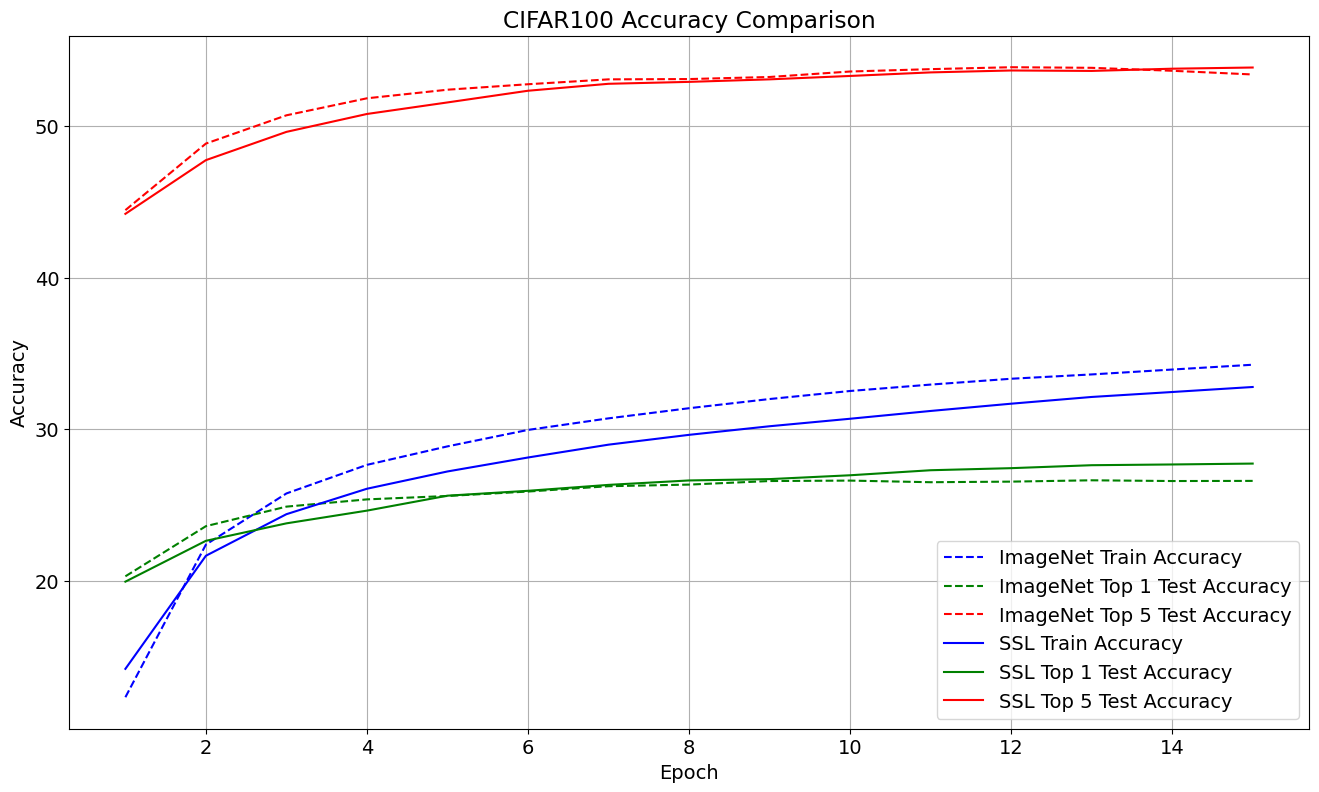

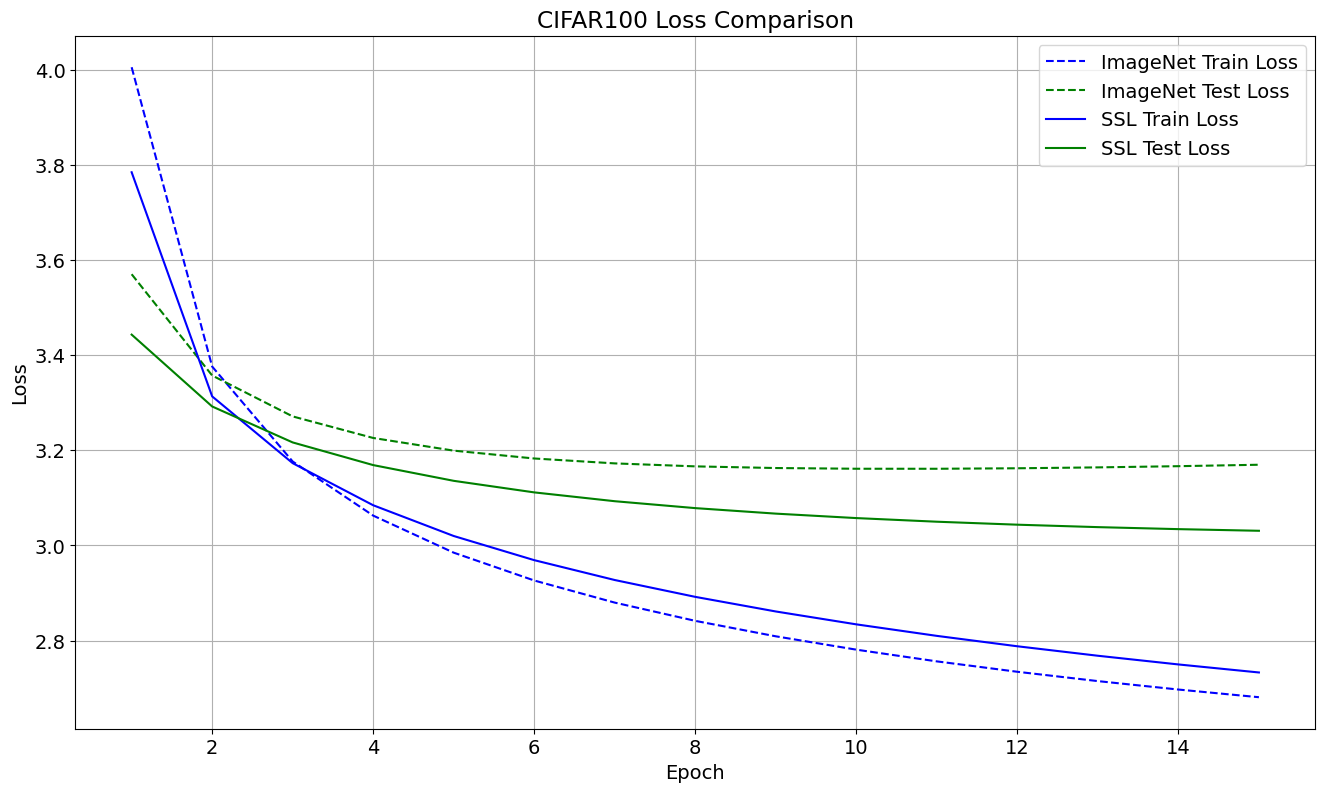

In [8]:

# 绘制 Accuracy 图
plt.figure(figsize=(16, 9))
plt.rcParams.update({'font.size': 14})
plt.title('CIFAR100 Accuracy Comparison')
plt.plot(epoch_list, imagenet_top1_train_accuracy, c='b', linestyle='--')
plt.plot(epoch_list, imagenet_top1_test_accuracy, c='g', linestyle='--')
plt.plot(epoch_list, imagenet_top5_test_accuracy, c='r', linestyle='--')
plt.plot(epoch_list, ssl_top1_train_accuracy, c='b')
plt.plot(epoch_list, ssl_top1_test_accuracy, c='g')
plt.plot(epoch_list, ssl_top5_test_accuracy, c='r')
plt.legend(['ImageNet Train Accuracy', 'ImageNet Top 1 Test Accuracy', 'ImageNet Top 5 Test Accuracy',
            'SSL Train Accuracy', 'SSL Top 1 Test Accuracy', 'SSL Top 5 Test Accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

# 绘制 Loss 图
plt.figure(figsize=(16, 9))
plt.rcParams.update({'font.size': 14})
plt.title('CIFAR100 Loss Comparison')
plt.plot(epoch_list, imagenet_train_loss, c='b', linestyle='--')
plt.plot(epoch_list, imagenet_test_loss, c='g', linestyle='--')
plt.plot(epoch_list, ssl_train_loss, c='b')
plt.plot(epoch_list, ssl_test_loss, c='g')
plt.legend(['ImageNet Train Loss', 'ImageNet Test Loss',
            'SSL Train Loss', 'SSL Test Loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()